<a href="https://colab.research.google.com/github/angel870326/XLNet_Text_Classification/blob/main/xlnet_multi_class_chinese_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 2022.05.14 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

# **XLNet Multi-class Text Classification for Chinese and English**
Available for both multi-lable and single-label.

## **Contents**
1. Dataset
   *   Raw dataset
   *   Clean dataset
   *   Convert 'product' to dummy variables
   *   Get small sample of train and test to try (optional)

2. Preprocessing<br/>
   (1) XLNetTokenizer & Sentence embedding<br/>
   (2) Tokenize input texts into ids<br/>
   (3) Create attention masks<br/>
   (4) Add input ids and attention masks to the dataframe<br/>
3. Train, Valid Split
4. Create Dataloaders (torch tensors)
5. Training<br/>
   (1) Functions<br/>
   (2) Train model from scratch<br/>
   (3) Train model from previous checkpoint<br/>
6. Get Predictions<br/>
   (1) Testing<br/>
   (2) For single-label classification<br/>
   (3) Save the predicting results<br/>


** Modified from  https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df*

In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 6.6 MB 48.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 60 kB/s 


In [ ]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# GPU
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **1. Dataset**


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Raw dataset

In [ ]:
train_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/資料檔/品類_clean.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/資料檔/原始資料/cat_test_v2(question).csv')

In [ ]:
train_raw.head()

,Unnamed: 0,name,product,clean_name
0,0,r視舒坦單支裝人工淚液點眼液0.5ml24支入,人工淚液,r視舒坦單支裝人工淚液點眼液入
1,1,優麗舒點眼液15ml,人工淚液,優麗舒點眼液
2,2,(r)視舒坦單支裝人工,人工淚液,r視舒坦單支裝人工
3,3,rohto乾眼淚液,人工淚液,rohto乾眼淚液
4,4,r參天柔潤人工淚液點眼液5ml4入,人工淚液,r參天柔潤人工淚液點眼液


In [ ]:
test_raw.head()

,name,occurred_at,iv_price,product,units,unit_price,total_price,channel
0,【施巴】嬌顏卸妝乳HA400ml,2022-01-08,968,NaN,1.0,705.0,705.0,bceb22fe7ebb8d831758f603636b37ec
1,艾瑪絲舒敏平衡洗髮精40,2022-01-02,3054,NaN,2.0,488.0,976.0,5a196ac44d260b2e4abcc5e8f863c0e5
2,【BB LOVE】高質感天絲TENCEL舖棉兩用兒童睡袋(多款可選),2022-01-02,586,NaN,1.0,990.0,990.0,bceb22fe7ebb8d831758f603636b37ec
3,Lovita愛維他-緩釋型維生素C 1000mg(60錠),2022-01-01,2180,NaN,1.0,440.0,440.0,4a3d67cc0cd76bf56f18b40ed671bb05
4,111262674618 CM 12公分長效Rifle風扇 1200轉,2022-01-07,129,NaN,1.0,129.0,129.0,fb92a6a55cb514d720672e54dbe11f15


### Clean dataset

In [ ]:
train_data = {'id': range(1, len(train_raw) + 1),
              'name': train_raw['clean_name'],
              'product': train_raw['product']}
train_clean = pd.DataFrame(train_data)
train_clean

,id,name,product
0,1,r視舒坦單支裝人工淚液點眼液入,人工淚液
1,2,優麗舒點眼液,人工淚液
2,3,r視舒坦單支裝人工,人工淚液
3,4,rohto乾眼淚液,人工淚液
4,5,r參天柔潤人工淚液點眼液,人工淚液
...,...,...,...
91914,91915,mdmmd微醺心機漸層腮紅-玫瑰瑪格麗特,腮紅
91915,91916,mdmmd微醺心機漸層腮紅-橙酒,腮紅
91916,91917,倫敦芮魅叛逆玩色腮紅盤005微醺酒紅,腮紅
91917,91918,palladio柔光幻彩貝殼腮紅微醺蜜桃,腮紅


In [ ]:
test_data = {'id': range(1, len(test_raw) + 1),
              'name': test_raw['name']}
test = pd.DataFrame(test_data)
test

,id,name
0,1,【施巴】嬌顏卸妝乳HA400ml
1,2,艾瑪絲舒敏平衡洗髮精40
2,3,【BB LOVE】高質感天絲TENCEL舖棉兩用兒童睡袋(多款可選)
3,4,Lovita愛維他-緩釋型維生素C 1000mg(60錠)
4,5,111262674618 CM 12公分長效Rifle風扇 1200轉
...,...,...
108846,108847,歐舒丹~橙花蘭花護手霜30ml
108847,108848,高露潔 360度抗敏專家牙刷(1入)
108848,108849,高露潔專業型超小刷頭密植軟毛牙刷6支裝【康是美】
108849,108850,熊寶貝 沁藍海洋香柔軟衣物護衣精2+6組 (3.2Lx2+1.84Lx6包)


### Convert 'product' to dummy variables

In [ ]:
train = train_clean[['id', 'name']]
products = pd.get_dummies(train_clean['product'])
train = pd.concat([train, products], axis=1)
train

,id,name,bb霜,cc霜,dd霜,rtd調酒,中式香腸,乳酸菌,人工淚液,保久乳,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
0,1,r視舒坦單支裝人工淚液點眼液入,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,優麗舒點眼液,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,r視舒坦單支裝人工,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,rohto乾眼淚液,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,r參天柔潤人工淚液點眼液,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91914,91915,mdmmd微醺心機漸層腮紅-玫瑰瑪格麗特,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91915,91916,mdmmd微醺心機漸層腮紅-橙酒,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91916,91917,倫敦芮魅叛逆玩色腮紅盤005微醺酒紅,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91917,91918,palladio柔光幻彩貝殼腮紅微醺蜜桃,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get small sample of train and test to try (optional)

In [ ]:
train = train.sample(n=1000)
test = train.sample(n=10)[['id','name']]

## **2. Preprocessing**


---



### (1) XLNetTokenizer & Sentence embedding

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
# XLNetTokenizer (for English)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# AutoTokenizer (for Chinese)
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/675k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [ ]:
# Texts for classification
train_text_list = train['name'].values
test_text_list = test['name'].values

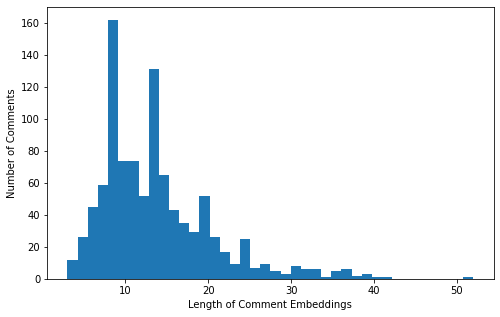

In [ ]:
# train
plot_sentence_embeddings_length(train_text_list, tokenizer)

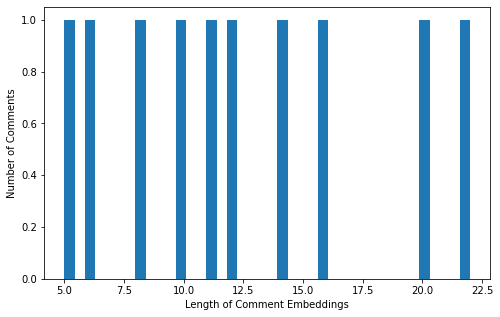

In [ ]:
# test
plot_sentence_embeddings_length(test_text_list, tokenizer)

### (2) Tokenize input texts into ids
*   Append the appropriate special characters to the end of the text to denote end of sentence.
*   Truncate or pad the appropriate sequence length.



In [ ]:
# 這裡可能要再改
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    # tokenize the text, then truncate sequence to the desired length minus 2 for the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [ ]:
# Create input id tokens (train)
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[   19,  2564, 15664, ...,     0,     0,     0],
       [   19,  5473,    95, ...,     0,     0,     0],
       [ 7801,   917, 17175, ...,     0,     0,     0],
       ...,
       [   19,  2400, 18718, ...,     0,     0,     0],
       [   19,    42,    83, ...,     0,     0,     0],
       [   19,  8114,  2114, ...,     0,     0,     0]])

In [ ]:
# Create input id tokens (test)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[   19,  1141, 11569, ...,     0,     0,     0],
       [   19,    59, 23183, ...,     0,     0,     0],
       [ 4531,  4615,    41, ...,     0,     0,     0],
       ...,
       [   19,  6064,   738, ...,     0,     0,     0],
       [   19,  2140, 21679, ...,     0,     0,     0],
       [   19,   971,   726, ...,     0,     0,     0]])

### (3) Create attention masks
*   Tell model whether attention should be applied to the input id tokens.
*   Do not want to perform attention on padding tokens.

In [ ]:
def create_attn_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# Create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

### (4) Add input ids and attention masks to the dataframe

In [ ]:
# train
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks
# test
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
train.head()

,id,name,bb霜,cc霜,dd霜,rtd調酒,中式香腸,乳酸菌,人工淚液,保久乳,...,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,features,masks
62423,62424,荷蘭blackrain男刷毛半門襟長袖上衣br-14176咖啡黑,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 2564, 15664, 7542, 2901, 1430, 1012, 1060...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
43564,43565,娘家益生菌包盒,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 5473, 95, 2118, 153, 2440, 970, 6759, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
29397,29398,realbarrier沛麗膚屏護保濕潔顏乳洗完不緊繃修復肌膚屏障效期2021,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[7801, 917, 17175, 2883, 994, 8515, 1627, 2235...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
51432,51433,魅光極線抗暈眼線液筆-,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 21020, 182, 1235, 191, 1952, 21566, 931, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
59603,59604,nugens捷視科技pc-freehdmi800萬實物攝影機限量贈送記憶卡無線滑鼠,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 629, 10829, 8899, 2735, 1378, 1682, 1116,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test.head()

,id,name,features,masks
90077,90078,hairrecipe蜂蜜保濕營養護髮精華素,"[19, 1141, 11569, 1958, 5263, 5304, 5398, 6027...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
26263,26264,一匙靈制菌洗衣精瓶裝,"[19, 59, 23183, 1565, 299, 2440, 21816, 1191, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
25412,25413,日本no1ariel日本進口三合一3d洗衣膠囊洗衣球室內晾乾六入箱,"[4531, 4615, 41, 8816, 1725, 161, 10046, 86, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
37753,37754,cnplaboratory蜂膠能量彈潤乳霜,"[19, 4447, 1116, 2453, 18960, 14707, 592, 5398...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
89670,89671,炫豔護髮染髮乳自然褐白染,"[19, 17141, 21748, 2267, 4532, 6342, 4532, 325...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## **3. Train, Valid Split**


---



In [ ]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

# products column names
label_cols = products.columns.values.tolist()
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## **4. Create Dataloaders (torch tensors)**
---

Convert all of the input ids and attention masks into torch tensors, the required datatype for the model.


In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. 
# With an iterator, the entire dataset does not need to be loaded into memory.
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## **5. Training**


---



### (1) Functions

Train the model and save the model with the lowest validation loss.

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
    """
    Training
    """
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      # scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    print("Train loss: {}".format(epoch_train_loss))

    """
    Validation
    """
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()
    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    # Update tracking variables
    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set

Save the model to the path directory provided.

In [ ]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

Load the model from the path directory provided.

In [ ]:
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### (2) Train model from scratch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    # self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.xlnet = AutoModel.from_pretrained("hfl/chinese-xlnet-base")
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Need GPU
# Modify output path

num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/xlnet_product.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.004937056757044047
Valid loss: 0.0018341614305973054


Epoch:  33%|███▎      | 1/3 [02:25<04:50, 145.15s/it]

Saving model at epoch 0 with validation loss of 0.0018341614305973054


Train loss: 0.001713361949659884
Valid loss: 0.001810633335262537


Epoch:  67%|██████▋   | 2/3 [04:43<02:21, 141.12s/it]

Saving model at epoch 1 with validation loss of 0.001810633335262537


Train loss: 0.0016926048835739494
Valid loss: 0.001785643445327878


Epoch: 100%|██████████| 3/3 [07:01<00:00, 140.59s/it]

Saving model at epoch 2 with validation loss of 0.001785643445327878




Text(0.5, 1.0, 'Loss vs Number of Epochs')

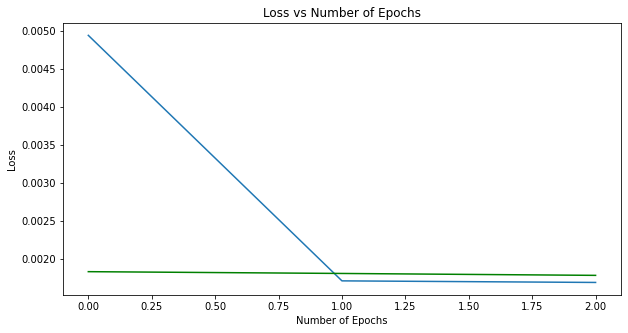

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

### (3) Train model from previous checkpoint

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/xlnet_product.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
num_epochs=3
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.001779610172379762


Epoch:  33%|███▎      | 1/3 [02:16<04:33, 136.62s/it]

Valid loss: 0.001828791666775942


Train loss: 0.001609007737133652
Valid loss: 0.001654445333406329


Epoch:  67%|██████▋   | 2/3 [04:35<02:17, 137.69s/it]

Saving model at epoch 3 with validation loss of 0.001654445333406329


Train loss: 0.0012759967183228582
Valid loss: 0.0012926842737942933


Epoch: 100%|██████████| 3/3 [06:53<00:00, 137.83s/it]

Saving model at epoch 4 with validation loss of 0.0012926842737942933




Text(0.5, 1.0, 'Loss vs Number of Epochs')

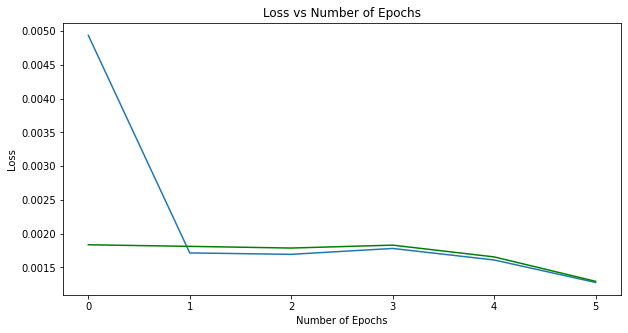

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## **6. Get Predictions**


---



### (1) Testing

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[7.23557954e-04, 2.81989138e-04, 3.07715498e-04, ...,
        6.77508933e-06, 1.31822156e-03, 7.61014991e-04],
       [5.03615593e-04, 7.38265298e-05, 3.91963311e-03, ...,
        1.99255592e-05, 1.46217272e-02, 1.29244691e-02],
       [2.80912849e-04, 5.89488845e-05, 4.16535558e-03, ...,
        5.71500823e-05, 1.03602104e-03, 2.39653490e-03],
       ...,
       [1.00547762e-03, 3.08516261e-04, 1.21603988e-03, ...,
        2.56056774e-05, 8.03853571e-03, 3.89410486e-03],
       [2.90283177e-04, 6.21911895e-05, 6.15084253e-04, ...,
        2.75567327e-05, 9.36885700e-02, 2.05611419e-02],
       [3.10399942e-03, 1.22190657e-04, 2.15629418e-03, ...,
        1.11240217e-04, 1.39068320e-01, 2.95488890e-02]])

In [ ]:
for i in label_cols:
  test[i] = pred_probs[:,label_cols.index(i)]

test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,features,masks,bb霜,cc霜,dd霜,rtd調酒,中式香腸,乳酸菌,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
90077,90078,hairrecipe蜂蜜保濕營養護髮精華素,"[19, 1141, 11569, 1958, 5263, 5304, 5398, 6027...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000724,0.000282,0.000308,0.000287,0.000375,0.000020,...,0.000002,0.000006,0.000154,0.000078,0.003564,0.063152,0.002056,0.000007,0.001318,0.000761
26263,26264,一匙靈制菌洗衣精瓶裝,"[19, 59, 23183, 1565, 299, 2440, 21816, 1191, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000504,0.000074,0.003920,0.003116,0.010640,0.000549,...,0.000043,0.000033,0.000022,0.000007,0.001343,0.002180,0.000737,0.000020,0.014622,0.012924
25412,25413,日本no1ariel日本進口三合一3d洗衣膠囊洗衣球室內晾乾六入箱,"[4531, 4615, 41, 8816, 1725, 161, 10046, 86, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000281,0.000059,0.004165,0.001291,0.002252,0.000193,...,0.000079,0.000028,0.000018,0.000137,0.000692,0.006967,0.001913,0.000057,0.001036,0.002397
37753,37754,cnplaboratory蜂膠能量彈潤乳霜,"[19, 4447, 1116, 2453, 18960, 14707, 592, 5398...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.002596,0.000229,0.003085,0.000308,0.000125,0.000020,...,0.000006,0.000016,0.000152,0.000124,0.002361,0.315388,0.001108,0.000037,0.000684,0.000405
89670,89671,炫豔護髮染髮乳自然褐白染,"[19, 17141, 21748, 2267, 4532, 6342, 4532, 325...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.002355,0.000100,0.000275,0.000443,0.000659,0.000018,...,0.000007,0.000010,0.000378,0.000127,0.001362,0.040070,0.003629,0.000009,0.002084,0.001049


### (2) For single-label classification

In [ ]:
# Get the maximum probability for each row
test['product'] = test.iloc[:,4:].idxmax(axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


### (3) Save the predicting results

In [ ]:
test_to_csv = test.reset_index()
test_to_csv.head()

,index,id,name,features,masks,bb霜,cc霜,dd霜,rtd調酒,中式香腸,...,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,product
0,90077,90078,hairrecipe蜂蜜保濕營養護髮精華素,"[19, 1141, 11569, 1958, 5263, 5304, 5398, 6027...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000724,0.000282,0.000308,0.000287,0.000375,...,0.000006,0.000154,0.000078,0.003564,0.063152,0.002056,0.000007,0.001318,0.000761,洗髮精
1,26263,26264,一匙靈制菌洗衣精瓶裝,"[19, 59, 23183, 1565, 299, 2440, 21816, 1191, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000504,0.000074,0.003920,0.003116,0.010640,...,0.000033,0.000022,0.000007,0.001343,0.002180,0.000737,0.000020,0.014622,0.012924,洗衣精
2,25412,25413,日本no1ariel日本進口三合一3d洗衣膠囊洗衣球室內晾乾六入箱,"[4531, 4615, 41, 8816, 1725, 161, 10046, 86, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000281,0.000059,0.004165,0.001291,0.002252,...,0.000028,0.000018,0.000137,0.000692,0.006967,0.001913,0.000057,0.001036,0.002397,洗衣精
3,37753,37754,cnplaboratory蜂膠能量彈潤乳霜,"[19, 4447, 1116, 2453, 18960, 14707, 592, 5398...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.002596,0.000229,0.003085,0.000308,0.000125,...,0.000016,0.000152,0.000124,0.002361,0.315388,0.001108,0.000037,0.000684,0.000405,面霜/乳霜
4,89670,89671,炫豔護髮染髮乳自然褐白染,"[19, 17141, 21748, 2267, 4532, 6342, 4532, 325...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.002355,0.000100,0.000275,0.000443,0.000659,...,0.000010,0.000378,0.000127,0.001362,0.040070,0.003629,0.000009,0.002084,0.001049,洗髮精


In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/product_1_epoch.csv")
test_to_csv.to_csv(pred_save_path, index=False)